<a href="https://colab.research.google.com/github/Luffyapo93/Pool/blob/main/Predicci%C3%B3n_Cripto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================
# 1. Importación de librerías
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ==========================
# 2. Cargar el dataset
# ==========================
# Ruta de tu archivo CSV
file_path = "/content/drive/MyDrive/Colab Notebooks/Archi_CSV/crypto-markets.csv"

df = pd.read_csv(file_path)

# Ver columnas disponibles
print(df.columns)

# Nos quedamos solo con la columna 'close'
data = df[['close']].dropna()


Index(['slug', 'symbol', 'name', 'date', 'ranknow', 'open', 'high', 'low',
       'close', 'volume', 'market', 'close_ratio', 'spread'],
      dtype='object')


In [2]:
# ==========================
# 3. Normalización con MinMaxScaler
# ==========================
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# ==========================
# 4. Crear secuencias para el LSTM
# ==========================
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Usamos 60 días como ventana de tiempo
time_step = 60
X, y = create_sequences(scaled_data, time_step)

# Dar forma a [samples, time_steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)


Forma de X: (942237, 60, 1)
Forma de y: (942237,)


In [3]:
# ==========================
# 5. Separar en entrenamiento (80%) y prueba (20%)
# ==========================
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Tamaño entrenamiento:", X_train.shape, y_train.shape)
print("Tamaño prueba:", X_test.shape, y_test.shape)


Tamaño entrenamiento: (753789, 60, 1) (753789,)
Tamaño prueba: (188448, 60, 1) (188448,)


In [4]:
# ==========================
# 6. Construcción del modelo LSTM
# ==========================
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Predicción de un valor

# Compilar modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,301 (493.36 KB)

 Trainable params: 126,301 (493.36 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ==========================
# 7. Entrenar modelo
# ==========================
history = model.fit(
    X_train, y_train,
    epochs=2+,              # Puedes aumentar si quieres
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/2
11778/11778 ━━━━━━━━━━━━━━━━━━━━ 2661s 226ms/step - loss: 1.8326e-07 - val_loss: 1.6471e-04
Epoch 2/2
11778/11778 ━━━━━━━━━━━━━━━━━━━━ 2763s 234ms/step - loss: 3.7474e-08 - val_loss: 1.6405e-04


5889/5889 ━━━━━━━━━━━━━━━━━━━━ 198s 34ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


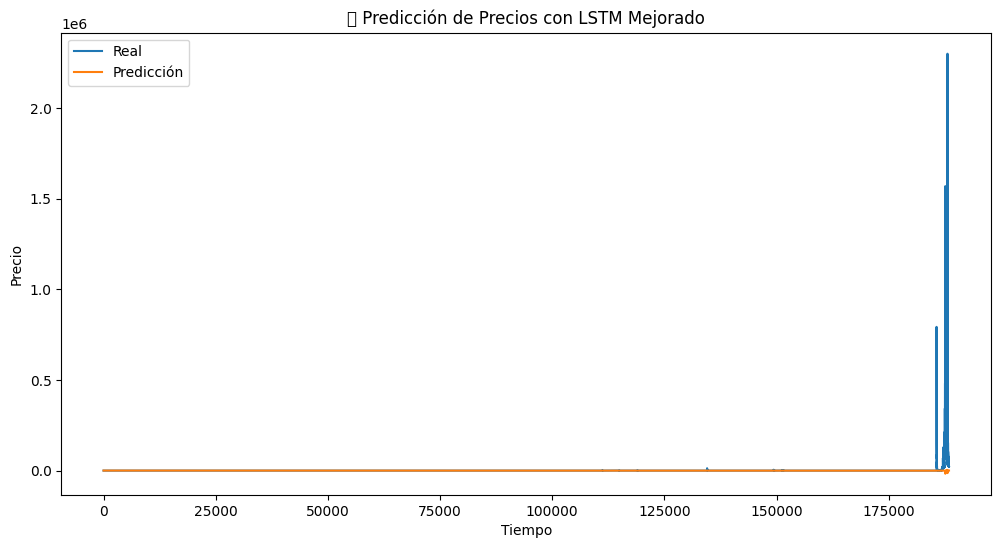

In [6]:
# ==========================
# 8. Predicciones
# ==========================
predictions = model.predict(X_test)

# Invertimos la escala para ver precios reales
predictions = scaler.inverse_transform(predictions.reshape(-1,1))
real = scaler.inverse_transform(y_test.reshape(-1,1))

# ==========================
# 9. Visualización de resultados
# ==========================
plt.figure(figsize=(12,6))
plt.plot(real, label='Real')
plt.plot(predictions, label='Predicción')
plt.title("📈 Predicción de Precios con LSTM Mejorado")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()
plt.show()


5889/5889 ━━━━━━━━━━━━━━━━━━━━ 197s 33ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


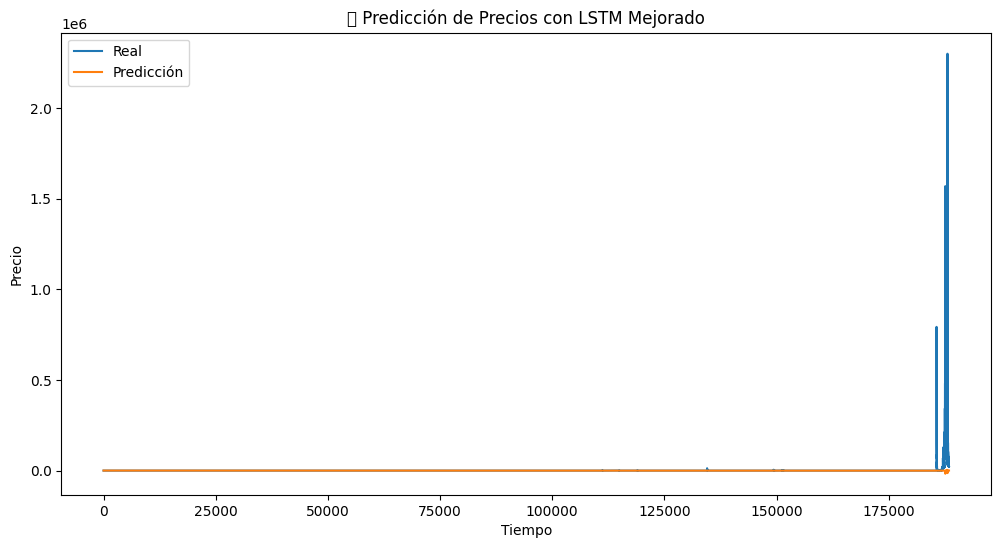

In [7]:
# ==========================
# 8. Predicciones
# ==========================
predictions = model.predict(X_test)

# Invertimos la escala para ver precios reales
predictions = scaler.inverse_transform(predictions.reshape(-1,1))
real = scaler.inverse_transform(y_test.reshape(-1,1))

# ==========================
# 9. Visualización de resultados
# ==========================
plt.figure(figsize=(12,6))
plt.plot(real, label='Real')
plt.plot(predictions, label='Predicción')
plt.title("📈 Predicción de Precios con LSTM Mejorado")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()
plt.show()


In [8]:
# ==========================
# 10. Calcular RMSE y MAPE
# ==========================
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(real, predictions))
mape = mean_absolute_percentage_error(real, predictions)

print("📊 Evaluación del modelo:")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


📊 Evaluación del modelo:
RMSE: 29467.986518265607
MAPE: 12263476.280098548
